# Staging Rasa Bot(Deposit) Data to Snowflake 

## Goal: Automate the process to write/update the most recent rasa data to snowflake, reserving historical changes. 

## Steps: shown below.

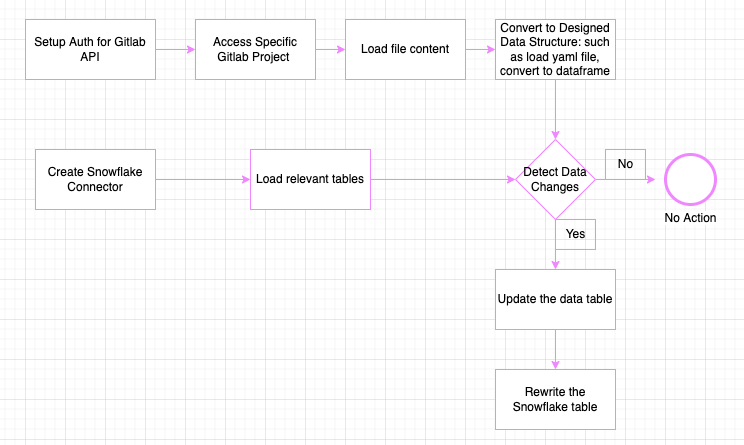

In [1]:
from IPython.display import display, HTML
# display(HTML("""
# <style>
# .output {
#     display: center;
#     # align-items: center;
#     text-align: center;
#     table {float:left}
# }
# </style>
# """))
from IPython.display import Image
Image(filename='workflow.png') 

<!-- !["Program Workflow"](workflow.png) -->


## Potential Conents 

- nlu/data: Intents & Training Data: NLU yaml files 

- nlu/data/lookups: escalation words, disaster, tax_form, third_party_app...

- test/data/* 

- synonyms 

- domain 

- Results 

## Enabled Functions 

- Deposit: Automate the training data extracting and writing to snowflake: "USER_SANDBOX_P.PZSW95.RARA_NLU_INTENT_UTTERANCES_TBL" 

- Deposit: Automate the lookup data extracting and writing to snowflake: "USER_SANDBOX_P.PZSW95.RARA_NLU_LOOKUP_TBL" 

- Deposit: Automate the synonym data extracting and writing to snowflake: "USER_SANDBOX_P.PZSW95.RARA_NLU_SYNONYM_TBL" 

- Deposit: Automate the test data extracting and writing to snowflake: "USER_SANDBOX_P.PZSW95.RARA_TEST_INTENT_UTTERANCES_TBL" 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import gitlab
import json
from pprint import pprint
import requests
import urllib.request
import yaml 
import utils as utils
import os 
import snowflake.db_connection as dbc
# Report the time when the program is running.
import datetime 
from pytz import timezone
import pandas as pd 
import datetime 

### Description (Data Source)
    - Loading data from https://gitlab.com/allyfinancial/ally-digital/applications/api/convo-ai/rasa 

        - Intent Utterances: yml files in data/nlu 

        - Synonyms: yml files in data/nlu 

        - Lookups: yml files in data/nlu/lookup_tables 

        - test data: test/data/nlu 

In [4]:
tz = timezone('US/Eastern')
space_trailing = '         '
# space_trailing = ''
load_date = datetime.datetime.now(tz)
text = "Report runtime: " + str(load_date)
print(space_trailing+"INFO: ",text)

# gitlab pulling data
p_token = os.environ.get('private_token', '')

#PLACE PRIVATE TOKEN HERE BUT DO NOT DEPLOY


# private token authentication
# gl = gitlab.Gitlab(url, private_token=p_token, ssl_verify=False) # 
gl = gitlab.Gitlab("https://gitlab.com", private_token=p_token, ssl_verify='./cert/Ally_CombinedCert.pem') #  
gl.auth()

project_url = "allyfinancial/ally-digital/applications/api/convo-ai/rasa"
project = gl.projects.get(project_url)

         INFO:  Report runtime: 2022-10-21 15:03:38.884748-04:00


In [5]:
# top 10 intents 
# from IPython.display import display, HTML
# print(space_trailing+f"INFO: Totally {train_data.INTENT.nunique()} intents - {len(train_data)} utterances in training data.")
# intent_freq = pd.DataFrame(train_data.INTENT.value_counts()).reset_index()
# # print(space_trailing+"INFO: Top 10 intents.")
# intent_freq.columns = ["Intent", "Counts"]
# CSS = """
# .output {
#     align-items: center;
#     display: flex; 
# }
# """
# HTML('<style>{}</style>'.format(CSS))
# text-align: center; 
# print(intent_freq.head(10))
# print(space_trailing+"INFO: Bottom 10 intents.")
# print(intent_freq.tail(10), )

In [6]:
##############################################################################
#Define the table name, schema, and database you want to write to

table_name = 'TBL_DIM_MASTER_UTTERANCE'
schema = 'CORE'
database = 'TEAM_TECH_CONVOAI_P'
usr = 'PZLYh9'


deposit_table_name_master_utter = "TBL_DIM_MASTER_UTTERANCE"
deposit_table_name_synonym = "TBL_DIM_RASA_NLU_SYNONYM" 
deposit_table_name_lookup = "TBL_DIM_RASA_NLU_LOOKUP" 
deposit_table_name_test_data = "TBL_DIM_RASA_TEST_INTENT_UTTERANCES" 
##############################################################################

In [7]:
# Load snowflake table 

snow = dbc.snowflake_connector(userid = usr, 
                    account='ally.us-east-1.privatelink',
                    warehouse='WH_TEAM_TECH_CONVOAI_ME', 
                    database=database, 
                    schema=schema)

#use "workbench" when working local, "prod" when deploying
snow.create_cursor(environment="prod", id_rsa_filename='id_rsa', passcode_filename='id_rsa_passcode')


In [9]:
### Training Data Extraction and Updating 
print(space_trailing+"INFO: Gettting Training Data")
# Training data: NLU YML files 
folder_path = 'data/nlu'
# folder_path = 'data/nlu/lookup_tables'
file_list, data_list = utils.get_all_yml_files(project, folder_path, branch='main')
nlu_intents = utils.get_intent_utterances(data_list)

total_intents = len(nlu_intents.keys())

train_data = pd.concat({k: pd.Series(v) for k, v in nlu_intents.items()})
train_data = train_data.to_frame().reset_index()
train_data.columns = ['INTENT', 'Index', 'UTTERANCE']
train_data = train_data.drop(columns=['Index'])

query = f'''SELECT * FROM{database}.{schema}.{deposit_table_name_master_utter}'''
df = snow.query_to_dataframe(query)
df['AI_PRODUCT'] = 'deposits'
change_trigger = False 
print(space_trailing + f"INFO: the snowflake table has {len(df)} rows!")
print(space_trailing + f"INFO: the train data has {len(train_data)} rows!")
display(df.head())

if (snow.error == 'program_error')|(len(df)==0): 
    # it could join other fields if needed. 
    print(space_trailing + f"INFO: Currently snowflake has no table {deposit_table_name_master_utter}")
    train_data['TRAINED'] = bool(1)
    train_data['INTENT_START_DATE'] ='2020-01-06'
    train_data['INTENT_END_DATE'] = '9999-01-01'
    train_data['LOAD_DATE'] = str(load_date)
    train_data['AI_PRODUCT'] = 'deposits'
    # print(space_trailing + f"INFO: snowflake connect error: {snow.error}")
    if(len(train_data)>0): 
        utils.write_data_to_snowflake(snow, train_data, table_name=deposit_table_name_master_utter)
else: 
    prev_data = df
    # detect the changes 
    change_trigger, output_df = utils.refresh_train_data(train_data, prev_data, load_date)
print(space_trailing + f"INFO: Detect Changes in NLU Training Data: {change_trigger} on {load_date}.")

if(change_trigger): 
    output_df = output_df[['INTENT','UTTERANCE', 'TRAINED', 'INTENT_START_DATE', 'INTENT_END_DATE','LOAD_DATE']]
    output_df = output_df.drop_duplicates()
    if(len(output_df)>0): 
        utils.write_data_to_snowflake(snow, output_df, table_name=deposit_table_name_master_utter)
else: 
    output_df = df 

         INFO: Gettting Training Data
         INFO: the snowflake table has 0 rows!
         INFO: the train data has 4897 rows!


Empty DataFrame
Columns: [AI_PRODUCT]
Index: []

         INFO: Currently snowflake has no table TBL_DIM_MASTER_UTTERANCE
         INFO: Create or replace the table: TBL_DIM_MASTER_UTTERANCE
         INFO: Totally 4897 rows are written to Snowflake Table.
         INFO: Detect Changes in NLU Training Data: False on 2022-10-21 15:03:38.884748-04:00.


In [10]:
# Extract Synonyms 
print(space_trailing+"INFO: Extracting Synonyms in RASA NLU YML Files!")
synonyms_dict = utils.get_synonyms(data_list)

synonyms_key = len(synonyms_dict.keys())

synonyms_data = pd.concat({k: pd.Series(v) for k, v in synonyms_dict.items()})
synonyms_data = synonyms_data.to_frame().reset_index()
synonyms_data.columns = ['SYNONYM', 'INDEX', 'WORD']
synonyms_data = synonyms_data.drop(columns=['INDEX'])
synonyms_data = synonyms_data.fillna("")
synonyms_data = synonyms_data[synonyms_data.WORD!=""]


query = f'''SELECT * FROM {database}.{schema}.{deposit_table_name_synonym}'''
df = snow.query_to_dataframe(query)

change_trigger = False 
print(space_trailing + f"INFO: the snowflake table has {len(df)} rows!")
print(space_trailing + f"INFO: the synonym data has {len(synonyms_data)} rows!")

if (snow.error == 'program_error')|(len(df)==0): 
    print(space_trailing + f"INFO: Currently snowflake has no table {deposit_table_name_synonym}")
    # it could join other fields if needed. 
    # print(space_trailing+"INFO: Updating the Lookup data per RASA Repository data changes.")
    synonyms_data['STATUS'] = bool(1)
    synonyms_data['START_DATE'] ='2020-01-06'
    synonyms_data['END_DATE'] = '9999-01-01'
    synonyms_data['LOAD_DATE'] = str(load_date)
    if(len(synonyms_data)>0): 
        utils.write_data_to_snowflake_synonym(snow, synonyms_data, deposit_table_name_synonym)
        # print(space_trailing + f"INFO: Create synonym table in snowflake with {len(synonyms_data)} rows!")
else: 
    prev_data = df
    # detect the changes 
    change_trigger, output_df = utils.refresh_synonym_data(synonyms_data, prev_data, load_date)
print(space_trailing + f"INFO: Detect Changes in NLU Lookup Data: {change_trigger} on {load_date}.")

if(change_trigger): 
    output_df = output_df[['SYNONYM','WORD', 'STATUS', 'START_DATE', 'END_DATE','LOAD_DATE']]
    output_df = output_df.drop_duplicates()
    if(len(output_df)>0): 
        utils.write_data_to_snowflake_synonym(snow, output_df, table_name=deposit_table_name_synonym)
display(df.head())

         INFO: Extracting Synonyms in RASA NLU YML Files!
         INFO: the snowflake table has 326 rows!
         INFO: the synonym data has 326 rows!
         INFO: Detect Changes in NLU Lookup Data: False on 2022-10-21 15:03:38.884748-04:00.


SYNONYM          WORD  STATUS START_DATE             END_DATE  \
0  transfer     transfers    True 2020-01-06  9999-01-01 00:00:00   
1  transfer    move money    True 2020-01-06  9999-01-01 00:00:00   
2  transfer  moving money    True 2020-01-06  9999-01-01 00:00:00   
3  transfer  transferring    True 2020-01-06  9999-01-01 00:00:00   
4  transfer   transferred    True 2020-01-06  9999-01-01 00:00:00   

                   LOAD_DATE  
0 2022-10-12 14:31:20.689929  
1 2022-10-12 14:31:20.689929  
2 2022-10-12 14:31:20.689929  
3 2022-10-12 14:31:20.689929  
4 2022-10-12 14:31:20.689929

In [11]:
#### Getting lookup tables 
print(space_trailing+"INFO: Gettting Lookup Files")
folder_path = 'data/nlu/lookup_tables'
# folder_path = 'data/nlu/lookup_tables'
file_list, data_list = utils.get_all_yml_files(project, folder_path, branch='main')
lookups_dict = utils.get_all_lookups(data_list)

lookup_key = len(lookups_dict.keys())

lookup_data = pd.concat({k: pd.Series(v) for k, v in lookups_dict.items()})
lookup_data = lookup_data.to_frame().reset_index()
lookup_data.columns = ['LOOKUP', 'INDEX', 'WORD']
lookup_data = lookup_data.drop(columns=['INDEX'])
lookup_data = lookup_data.fillna("")
lookup_data = lookup_data[lookup_data.WORD!=""]
# display(lookup_data.head())

query = f'''SELECT * FROM {database}.{schema}.{deposit_table_name_lookup}'''
df = snow.query_to_dataframe(query)

change_trigger = False 
print(space_trailing + f"INFO: the snowflake table has {len(df)} rows!")
print(space_trailing + f"INFO: the lookup data has {len(lookup_data)} rows!")
display(df.head())

if (snow.error == 'program_error')|(len(df)==0): 
    # it could join other fields if needed. 
    print(space_trailing + f"INFO: Currently snowflake has no table {deposit_table_name_lookup}")
    lookup_data['STATUS'] = bool(1)
    lookup_data['START_DATE'] ='2020-01-06'
    lookup_data['END_DATE'] = '9999-01-01'
    lookup_data['LOAD_DATE'] = str(load_date)
    # print(space_trailing + f"INFO: snowflake connect error: {snow.error}")
    if(len(lookup_data)>0): 
        utils.write_data_to_snowflake_lookup(snow, lookup_data, deposit_table_name_lookup)
else: 
    prev_data = df
    # detect the changes 
    change_trigger, output_df = utils.refresh_lookup_data(lookup_data, prev_data, load_date)
print(space_trailing + f"INFO: Detect Changes in NLU Lookup Data: {change_trigger} on {load_date}.")

if(change_trigger): 
    output_df = output_df[['LOOKUP','WORD', 'STATUS', 'START_DATE', 'END_DATE','LOAD_DATE']]
    output_df = output_df.drop_duplicates()
    if(len(output_df)>0): 
        utils.write_data_to_snowflake_lookup(snow, output_df, table_name=deposit_table_name_lookup)


         INFO: Gettting Lookup Files
         INFO: the snowflake table has 379 rows!
         INFO: the lookup data has 379 rows!


LOOKUP      WORD  STATUS START_DATE             END_DATE  \
0  tax_form      1099    True 2020-01-06  9999-01-01 00:00:00   
1  tax_form    1099-r    True 2020-01-06  9999-01-01 00:00:00   
2  tax_form    1099 r    True 2020-01-06  9999-01-01 00:00:00   
3  tax_form     1099r    True 2020-01-06  9999-01-01 00:00:00   
4  tax_form  1099-int    True 2020-01-06  9999-01-01 00:00:00   

                   LOAD_DATE  
0 2022-10-12 14:31:20.689929  
1 2022-10-12 14:31:20.689929  
2 2022-10-12 14:31:20.689929  
3 2022-10-12 14:31:20.689929  
4 2022-10-12 14:31:20.689929

         INFO: Detect Changes in NLU Lookup Data: False on 2022-10-21 15:03:38.884748-04:00.


In [12]:
### Testing Data Extraction and Updating 
print(space_trailing+"INFO: Gettting Testing Data")
# Testing data: test YML files 
folder_path = 'test/data/nlu'
file_list, data_list = utils.get_all_yml_files(project, folder_path, branch='main')
nlu_intents = utils.get_intent_utterances(data_list)

total_intents = len(nlu_intents.keys())
print(space_trailing+f"Totally {total_intents} intents of test data.")
test_data = pd.concat({k: pd.Series(v) for k, v in nlu_intents.items()})
test_data = test_data.to_frame().reset_index()
test_data.columns = ['INTENT', 'Index', 'UTTERANCE']
test_data = test_data.drop(columns=['Index'])
print(space_trailing+f"Totally {len(test_data)} utterances of test data.")

query = f'''SELECT * FROM {database}.{schema}.{deposit_table_name_test_data}'''

df = snow.query_to_dataframe(query)
df['AI_PRODUCT'] = 'deposits'
print(space_trailing+f"Totally {len(df)} utterances in snowflake test data.")
change_trigger = False 
if (snow.error == 'program_error') | (len(df) == 0): 
    # it could join other fields if needed. 
    print(space_trailing + f"INFO: Currently snowflake has no table {deposit_table_name_test_data}")
    test_data['STATUS'] = bool(1)
    test_data['INTENT_START_DATE'] ='2020-01-06'
    test_data['INTENT_END_DATE'] = '9999-01-01'
    test_data['LOAD_DATE'] = str(load_date)
    test_data['AI_PRODUCT'] = 'deposits'
    print(space_trailing + f"INFO: snowflake connect error: {snow.error}")
    if(len(test_data)>0): 
        utils.write_test_data_to_snowflake(snow, test_data, table_name=deposit_table_name_test_data)
else: 
    # detect the changes 
    change_trigger, output_df = utils.refresh_test_data(test_data, df, load_date)
print(space_trailing + f"INFO: Detect Changes in NLU Training Data: {change_trigger} on {load_date}.")

if(change_trigger): 
    output_df = output_df[['INTENT','AI_PRODUCT', 'UTTERANCE', 'STATUS', 'INTENT_START_DATE', 'INTENT_END_DATE','LOAD_DATE']]
    output_df = output_df.drop_duplicates()
        
    if(len(output_df)>0): 
        utils.write_test_data_to_snowflake(snow, output_df, table_name=deposit_table_name_test_data)
        print(space_trailing + f"INFO: Writting {len(output_df)} rows to test data.")

display(df.head())

         INFO: Gettting Testing Data
         Totally 79 intents of test data.
         Totally 3004 utterances of test data.
         Totally 3004 utterances in snowflake test data.
         INFO: Detect Changes in NLU Training Data: False on 2022-10-21 15:03:38.884748-04:00.


INTENT                                          UTTERANCE  STATUS  \
0  ach_fee_refund  I got charged with an excessive transfer fee? ...    True   
1  ach_fee_refund  Are you refunding the $10 x 4 for transferring...    True   
2  ach_fee_refund  Hello I was charged an excessive transfer fee....    True   
3  ach_fee_refund  Didn 't mean to do another transfer. Please re...    True   
4  ach_fee_refund  I am just double checking that all excessive t...    True   

  INTENT_START_DATE      INTENT_END_DATE                  LOAD_DATE AI_PRODUCT  
0        2020-01-06  9999-01-01 00:00:00 2022-10-12 14:31:20.689929   deposits  
1        2020-01-06  9999-01-01 00:00:00 2022-10-12 14:31:20.689929   deposits  
2        2020-01-06  9999-01-01 00:00:00 2022-10-12 14:31:20.689929   deposits  
3        2020-01-06  9999-01-01 00:00:00 2022-10-12 14:31:20.689929   deposits  
4        2020-01-06  9999-01-01 00:00:00 2022-10-12 14:31:20.689929   deposits

In [ ]:
output_df.info()